In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

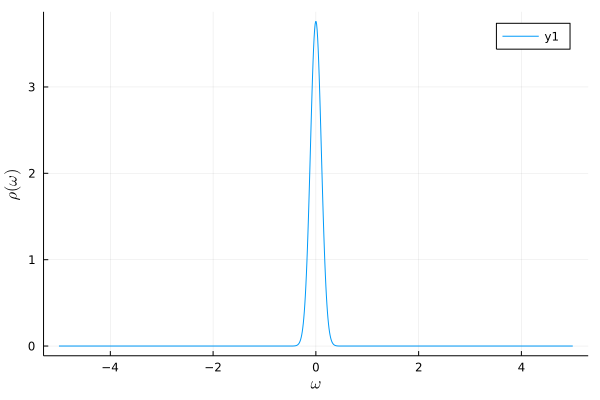

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian
rho(omega) = gaussian(omega, 0.0, 0.15)  

#rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

38

In [8]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [9]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [10]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H         =  50
ab_coeff  = zeros(ComplexF64, 2*H) 
lambda    = 1e-5
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 15
N_imp 15


In [11]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H, lambda, true)
;

Pick matrix is positive semi-definite.
H= 1
Iter     Function value   Gradient norm 
     0     8.958464e+00     1.085988e+02
 * time: 0.02180004119873047
     1     7.378953e+00     2.464467e+01
 * time: 2.467982053756714
     2     3.520143e+00     4.766361e+01
 * time: 2.7945189476013184
     3     3.349490e+00     3.160790e+01
 * time: 2.9975640773773193
     4     1.859782e+00     6.575833e+01
 * time: 3.1919379234313965
     5     8.347869e-01     1.983128e+01
 * time: 3.3991780281066895
     6     3.815187e-01     7.633558e+00
 * time: 3.5889530181884766
     7     3.519835e-01     1.831780e+00
 * time: 3.888792037963867
     8     3.496181e-01     2.231984e+00
 * time: 4.087130069732666
     9     3.480403e-01     5.364566e-01
 * time: 4.2982518672943115
    10     3.479148e-01     2.713941e-01
 * time: 4.5199949741363525
    11     3.478890e-01     1.971813e-01
 * time: 4.821290016174316
    12     3.478817e-01     7.717652e-02
 * time: 5.026155948638916
    13     3.478792e-0

In [12]:
@time Nevanlinna.solve(sol)

H= 1
Iter     Function value   Gradient norm 
     0     8.958464e+00     1.085988e+02
 * time: 0.000270843505859375
     1     7.378953e+00     2.464467e+01
 * time: 1.155789852142334
     2     3.520143e+00     4.766361e+01
 * time: 1.4628498554229736
     3     3.349490e+00     3.160790e+01
 * time: 1.6612110137939453
     4     1.859782e+00     6.575833e+01
 * time: 1.8692188262939453
     5     8.347869e-01     1.983128e+01
 * time: 2.0874838829040527
     6     3.815187e-01     7.633558e+00
 * time: 2.3072829246520996
     7     3.519835e-01     1.831780e+00
 * time: 2.634408950805664
     8     3.496181e-01     2.231984e+00
 * time: 2.849238872528076
     9     3.480403e-01     5.364566e-01
 * time: 3.037933826446533
    10     3.479148e-01     2.713941e-01
 * time: 3.238330841064453
    11     3.478890e-01     1.971813e-01
 * time: 3.557377815246582
    12     3.478817e-01     7.717652e-02
 * time: 3.750269889831543
    13     3.478792e-01     4.889332e-02
 * time: 4.0564129352

    77     1.509715e-01     1.314561e-06
 * time: 19.27408504486084
    78     1.509715e-01     1.045263e-06
 * time: 19.495023012161255
    79     1.509715e-01     7.731601e-07
 * time: 19.718852043151855
    80     1.509715e-01     6.013519e-07
 * time: 19.947816133499146
    81     1.509715e-01     4.457338e-07
 * time: 20.190283060073853
    82     1.509715e-01     3.477929e-07
 * time: 20.421112060546875
    83     1.509715e-01     2.478553e-07
 * time: 20.63283109664917
    84     1.509715e-01     1.986068e-07
 * time: 20.853454113006592
    85     1.509715e-01     1.403697e-07
 * time: 21.08428406715393
    86     1.509715e-01     1.131402e-07
 * time: 21.310704946517944
max_theta=1.12596773419453448570219070962566278078149253791748225525960330151786280571979296331829520888510176408669208690876033625871322090635071435091089839204962011
hardy optimization was failure.
H= 3
Iter     Function value   Gradient norm 
     0     1.509715e-01     1.823066e-04
 * time: 0.000203132629394

   106     1.509682e-01     8.284200e-03
 * time: 32.21338200569153
   107     1.509682e-01     8.797176e-03
 * time: 32.465747117996216
   108     1.509682e-01     8.838418e-03
 * time: 32.71520018577576
   109     1.509682e-01     9.374684e-03
 * time: 32.966031074523926
   110     1.509682e-01     9.419522e-03
 * time: 33.244194984436035
   111     1.509682e-01     9.979638e-03
 * time: 33.48461699485779
   112     1.509682e-01     1.002909e-02
 * time: 33.76247215270996
   113     1.509682e-01     1.061267e-02
 * time: 34.034438133239746
   114     1.509682e-01     1.066779e-02
 * time: 34.27666401863098
   115     1.509682e-01     1.127440e-02
 * time: 34.532881021499634
   116     1.509682e-01     1.133569e-02
 * time: 34.796936988830566
   117     1.509682e-01     1.196557e-02
 * time: 35.043137073516846
   118     1.509682e-01     1.203298e-02
 * time: 35.311177015304565
   119     1.509682e-01     1.268688e-02
 * time: 35.5642249584198
   120     1.509682e-01     1.276026e-02


   227     1.509642e-01     9.754610e-07
 * time: 68.41337609291077
   228     1.509642e-01     5.235869e-07
 * time: 68.65563607215881
   229     1.509642e-01     6.785498e-07
 * time: 69.06050610542297
   230     1.509642e-01     3.121188e-07
 * time: 69.3024070262909
   231     1.509642e-01     4.479784e-07
 * time: 69.68917918205261
   232     1.509642e-01     1.919139e-07
 * time: 69.93360900878906
   233     1.509642e-01     2.635667e-07
 * time: 70.20250797271729
   234     1.509642e-01     1.388902e-07
 * time: 70.45698618888855
   235     1.509642e-01     1.713697e-07
 * time: 70.83560800552368
   236     1.509642e-01     9.750551e-08
 * time: 71.10502219200134
   237     1.509642e-01     1.190215e-07
 * time: 71.51752495765686
max_theta=1.65200842563750704963953908548361502758348500035599631036150164123649640891025764116147824926404083417267522399154796230145466534180656897097193858213567683
hardy optimization was failure.
104.693879 seconds (1.42 G allocations: 94.911 GiB, 2

In [13]:
error = Nevanlinna.calc_error(sol.reals, sol.matsu_omega, sol.matsu_green)

0.00177539574690698440763649498293902038502645660469223026078789963385291194786257501517508622647658729070422451352248012893398607492647870706948224977408249485

In [14]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H)

Nevanlinna.evaluation(raw_reals, abcd, H, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


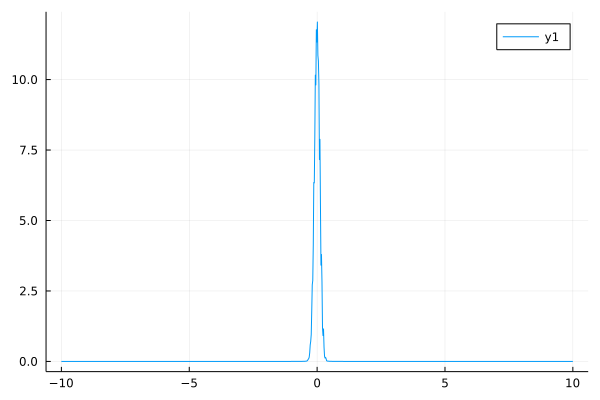

In [15]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))
#plot!(omegas, rho.(omegas))

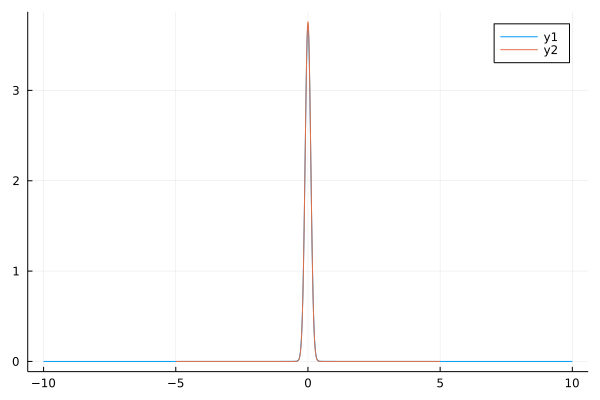

In [16]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [17]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [18]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#